In [1]:
!pip install seaborn
!pip install ipywidgets
!pip install lightgbm

In [2]:
import os
import gc
import random
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
#import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from datetime import datetime
from scipy import sparse
from scipy.sparse import csr_matrix
from ipywidgets import interact
from IPython.display import Image

# Scikit-Learn Imports
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import lightgbm as lgb
# Configuration
# matplotlib.use('nbagg')
# plt.rcParams.update({'figure.max_open_warning': 0})
sns.set_style('whitegrid')


In [3]:
# plot line figure
def line_plot(x_d,y_d,title='',xlabel='',ylabel=''):
    plt.plot(x_d, y_d,marker='.')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

In [4]:
def handle_bad_lines(line):
    fields =[str(field) for field in line]
    movie_id = int(fields[0])
    release_year = int(fields[1])
    combined_title = ''.join(fields[2:]).strip()
    return movie_id, release_year, combined_title

movie_titles_df = pd.read_csv('movie_titles.csv', names = ['MovieId', 'ReleaseYear', 'MovieTitle'], encoding='ISO-8859-1', engine='python', on_bad_lines=handle_bad_lines)
movie_titles_df['ReleaseYear'] = movie_titles_df['ReleaseYear'].astype('Int64')
movie_titles_df.head()


,MovieId,ReleaseYear,MovieTitle
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW


In [5]:
movie_titles_df['ReleaseYear'].value_counts()

ReleaseYear
2004    1436
2002    1310
2003    1271
2000    1234
2001    1184
        ... 
1918       2
1923       2
1914       2
1909       1
1896       1
Name: count, Length: 94, dtype: Int64

<Axes: >

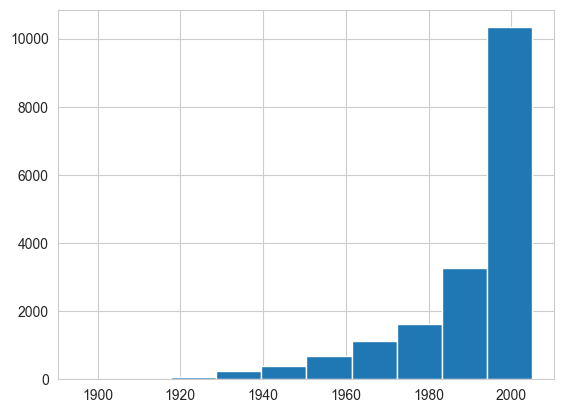

In [6]:
movie_titles_df['ReleaseYear'].hist()

In [7]:
# Feature binning model
from sklearn.preprocessing import KBinsDiscretizer

kbmodel = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile') # strategies: uniform quantile kmeans

result = kbmodel.fit_transform(movie_titles_df[pd.isna(movie_titles_df['ReleaseYear'])==False]['ReleaseYear'].values.reshape(-1, 1))

bin_edge = kbmodel.bin_edges_

In [8]:
bin_edge

array([array([1896., 1980., 1994., 1999., 2002., 2005.])], dtype=object)

In [9]:
movie_titles_df['ReleaseYear_Bin'] = -1
movie_titles_df.loc[(movie_titles_df['ReleaseYear']>=bin_edge[0][0])&(movie_titles_df['ReleaseYear']<bin_edge[0][1]),'ReleaseYear_Bin'] = 0
movie_titles_df.loc[(movie_titles_df['ReleaseYear']>=bin_edge[0][1])&(movie_titles_df['ReleaseYear']<bin_edge[0][2]),'ReleaseYear_Bin'] = 1
movie_titles_df.loc[(movie_titles_df['ReleaseYear']>=bin_edge[0][2])&(movie_titles_df['ReleaseYear']<bin_edge[0][3]),'ReleaseYear_Bin'] = 2
movie_titles_df.loc[(movie_titles_df['ReleaseYear']>=bin_edge[0][3])&(movie_titles_df['ReleaseYear']<bin_edge[0][4]),'ReleaseYear_Bin'] = 3
#movie_titles_df.loc[(movie_titles_df['m102_sum']>=bin_edge[0][2])&(movie_titles_df['m102_sum']<bin_edge[0][3]),'ReleaseYear_Bin'] = 2
movie_titles_df.loc[(movie_titles_df['ReleaseYear']>=bin_edge[0][4]),'ReleaseYear_Bin'] = 4

In [10]:
movie_titles_df['ReleaseYear_Bin'].value_counts()

ReleaseYear_Bin
 4    4529
 0    3507
 1    3466
 3    3383
 2    2878
-1       7
Name: count, dtype: int64

<Axes: >

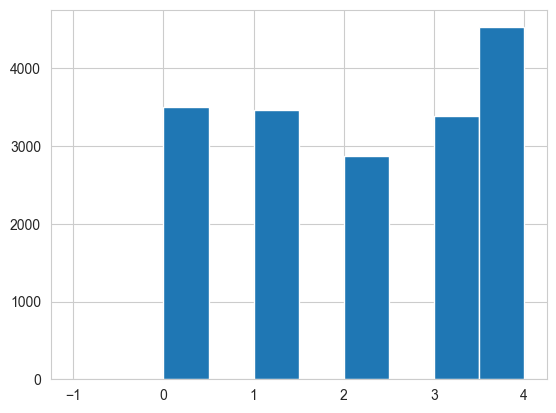

In [11]:
movie_titles_df['ReleaseYear_Bin'].hist()

In [12]:
# Processing training data
start = datetime.now()
if not os.path.isfile('data.csv') and not os.path.isfile('featured_train_test_data.csv'):
    data = open('data.csv', mode='w')
    
    row = list()
    files = [
        'combined_data_1.txt',
        'combined_data_2.txt', 
        'combined_data_3.txt', 
        'combined_data_4.txt'
    ]
    for file in files:
        print("Reading ratings from {}\n".format(file))
        with open(file) as f:
            for line in f: 
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
    data.close()
print('Time taken :', datetime.now() - start)

Time taken : 0:00:00.000998


In [13]:
#feature engineering
if  not os.path.isfile('featured_train_test_data.csv'):
    # Convert training data to pandas dataframe
    df = pd.read_csv('data.csv', sep=',', 
        names=['movie', 'user', 'rating', 'date'])
    df.date = pd.to_datetime(df.date)
    #Shuffle the training data to eliminate the influence of time, so that the model doesn’t miss out on learning about new movies.
    df = df.sample(frac=1)
    df = df.reset_index(drop=True)
    # Rename the primary key from movieid to movie, preparing for the next merge
    movie_df = movie_titles_df.rename(index=str,inplace=False,columns={'MovieId':'movie'})
    movie_df.head()
    # adding the movie's ReleaseYear and releaseYaer_BIn
    df_t = df.merge(movie_df[['movie','ReleaseYear','ReleaseYear_Bin']],how='left',on='movie')
    df_t.head()
    # constructing the composite primary key
    df_t['movie_user']=df_t['movie'].astype(str)+df_t['user'].astype(str)
    df_t.head()
    # calculating feature: time difference between watching date and ReleaseYear
    df_t['watch_year_dif']=df_t['date'].dt.year-df_t['ReleaseYear']
    df_t.head()
    # Constructing onehot feature from binning, representing the category of ReleaseYear
    cata_cols=['ReleaseYear_Bin']
    
    one_hot = {'ReleaseYear_Bin': [0,1,2,3,4]}
    for col in one_hot:
        for val in one_hot[col]:
            #print(col)
            #print(val)
            df_t['hot_' + col + '_' +str(val)] = 1*(df_t[col].values == val)
    df = df_t
    del df_t
    gc.collect()
    #The above constructs the features: watch_year_dif: the difference between the viewing time and the release time of the film; 
    #the onehot feature constructed based on the data binning (5 bins, each bin represents a decade), representing the decade of the movie;
else:
    print("featured_train_test_data.csv File exists")

featured_train_test_data.csv File exists


Construct sparse matrix and divide it into training and testing

In [14]:
start = datetime.now()
if os.path.isfile('train_sparse_matrix.npz'):
    train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
else: 
    train_sparse_matrix = sparse.csr_matrix((
        df.rating.values, (df.user.values,df.movie.values)
    ))
    
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
    sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
    
print(datetime.now() - start)

0:00:05.186610


In [15]:
# Extracting samples from a sparse matrix
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    """
    It will get it from the ''path'' if it is present  or it will create 
    and store the sampled sparse matrix in the path specified.
    """
    
    # Get (row, col) and (rating) tuple from sparse_matrix.
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix: (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix: Ratings -- {}\n".format(len(ratings)))

    # It's just to make sure to get same sample everytime we run this program & pick without replacement
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    
    # Get the boolean mask of these sampled_items in originl row/col_inds.
    mask = np.logical_and(np.isin(row_ind, sample_users), np.isin(col_ind, sample_movies))
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
         shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for further usage!')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done')
    
    return sample_sparse_matrix

Extracting samples - training and testing

In [16]:
start = datetime.now()
#path = "/kaggle/working/sample_train_sparse_matrix.npz"
path = "sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk!")
    # Just get it from the disk instead of computing it
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("Done")
else: 
    # Get 10k users and 1k movies from available data 
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=10000, 
        no_movies=1000, path = path)
    #sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=2000, 
    #    no_movies=500, path = path)
print(datetime.now() - start)

It is present in your pwd, getting it from disk!
Done
0:00:00.045710


In [17]:
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [18]:
sample_train_users

array([     83,     188,     188, ..., 2649067, 2649067, 2649067])

In [19]:
# Calculating the average rating score
def get_average_ratings(sparse_matrix, of_users):
    # Average ratings of user/movies
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes
    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings (whether a user rated that movie or not)
    is_rated = (sparse_matrix != 0)
    # No of ratings for each user/movie
    no_of_ratings = is_rated.sum(axis=ax).A1
    # max_user and max_movie ids in sparse matrix 
    u, m = sparse_matrix.shape
    # Create a dictonary of users and their average ratings
    average_ratings = {i : sum_of_ratings[i] / no_of_ratings[i]
         for i in range(u if of_users else m) if no_of_ratings[i] != 0}

    # Return that dictionary of average ratings
    return average_ratings

# Counting the total number of movies watched by a user, and the total number of users being watched by a movie
def get_counts(sparse_matrix, of_users):
    # 
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes
    # Boolean matrix of ratings (whether a user rated that movie or not)
    is_rated = (sparse_matrix != 0)
    # No of ratings for each user/movie
    no_of_ratings = is_rated.sum(axis=ax).A1
    # max_user and max_movie ids in sparse matrix 
    u, m = sparse_matrix.shape
    # Create a dictonary of users or movie counts
    counts = {i : no_of_ratings[i]
         for i in range(u if of_users else m) if no_of_ratings[i] != 0}

    # Return that dictionary of counts
    return counts

# Count the highest score ever rated by a user and the highest score ever rated by a movie
def get_max_ratings(sparse_matrix, of_users):
    # 
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # Max rating index for each user/movie
    max_indices = sparse_matrix.argmax(axis=ax)
    
    # max_user and max_movie ids in sparse matrix 
    u, m = sparse_matrix.shape
    # Create a dictonary of users and their max ratings
    counts = {i : sparse_matrix[i,max_indices[i,0]] if of_users else sparse_matrix[max_indices[0,i],i]
         for i in range(u if of_users else m) }

    # Return that dictionary of counts
    return counts

# Count the lowest score ever rated by a user and the lowest score ever rated by a movie
def get_min_ratings(sparse_matrix, of_users):
    #
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes
    # min rating index for each user/movie
    min_indices = sparse_matrix.argmin(axis=ax) 
    # max_user and max_movie ids in sparse matrix 
    u, m = sparse_matrix.shape
    # Create a dictonary of users and their min ratings
    counts = {i : sparse_matrix[i,min_indices[i,0]] if of_users else sparse_matrix[min_indices[0,i],i]
         for i in range(u if of_users else m) }

    # Return that dictionary of counts
    return counts
    

In [20]:
# Construct a dictionary to query data by userid or movieid
if  not os.path.isfile('featured_train_test_data.csv'):
    sample_train_averages = dict()
    global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
    sample_train_averages['global'] = global_average
    # Average rating score of users
    sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
    # Average movie rating score
    sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
    # Number of movie viewings of a user
    sample_train_averages['user_watched_'] = get_counts(sample_train_sparse_matrix, of_users=True)
    # Watches of a movie
    sample_train_averages['movie_watched_'] =  get_counts(sample_train_sparse_matrix, of_users=False)
    # The highest score rated by users
    sample_train_averages['user_max_rating'] = get_max_ratings(sample_train_sparse_matrix, of_users=True)
    # The highest rating a movie has ever received
    sample_train_averages['movie_max_rating'] =  get_max_ratings(sample_train_sparse_matrix, of_users=False)
    # The lowest score rated by users
    sample_train_averages['user_min_rating'] = get_min_ratings(sample_train_sparse_matrix, of_users=True)
    # The lowest rating a movie has ever received
    sample_train_averages['movie_min_rating'] =  get_min_ratings(sample_train_sparse_matrix, of_users=False)

In [21]:
#os.remove("featured_reg_train.csv")

By calculating the scores of similar users for movies and the scores of users for similar movies, we construct features and output training and test data

In [22]:
start = datetime.now()
if os.path.isfile('featured_reg_train.csv'):
    print("File already exists you don't have to prepare again!")
else:
    print('Preparing {} tuples for the dataset'.format(len(sample_train_ratings)))
    with open('featured_reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
            # =============================================
            # Ratings of "movie" by similar users of "user"
            # =============================================
            
            # Compute the similar Users of the "user"        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            # We are ignoring 'The User' from its similar users
            top_sim_users = user_sim.argsort()[::-1][1:] 
            # Get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # We will make it's length "5" by adding movie averages to the rest of the cells.
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            #top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
            # If the ratings are less than 5, use similar movies' ratings for this user
            if len(top_sim_users_ratings) < 5:
                # Compute the similar movies of the target movie
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:, movie].T, sample_train_sparse_matrix.T).ravel()
                # Ignore the target movie itself
                top_sim_movies = movie_sim.argsort()[::-1][1:11]  # Top 5 similar movies

                # Get the average ratings of the similar movies rated by the current similar user
                additional_ratings = []
                for sim_movie in top_sim_movies:
                    movie_ratings = sample_train_sparse_matrix[top_sim_users, sim_movie].toarray().ravel()
                    movie_avg = movie_ratings[movie_ratings != 0].mean() if (movie_ratings != 0).any() else None
                    if movie_avg is not None:
                        additional_ratings.append(movie_avg)
                        if len(top_sim_users_ratings) + len(additional_ratings) >= 5:
                            break

                # Add the additional ratings to top_sim_users_ratings
                top_sim_users_ratings.extend(additional_ratings)

            # If still not enough, fill the rest with the movie's global average
            if len(top_sim_users_ratings) < 5:
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]] * (5 - len(top_sim_users_ratings)))

            # ==============================================
            # Ratings by "user"  to similar movies of "movie"
            # ==============================================
            
            # Compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            # We are ignoring 'The Movie' from its similar movies.
            top_sim_movies = movie_sim.argsort()[::-1][1:] 
            # Get the ratings of most similar movie rated by this user
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # We will make it's length "5" by adding user averages to the rest of the cells
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            #top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
            # If ratings are less than 5, use ratings from similar users for this similar movie
            if len(top_sim_movies_ratings) < 5:
                # Compute the similar users of the current user
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                # Ignore the target user
                top_sim_users = user_sim.argsort()[::-1][1:]  # Top similar users

                # Get the average rating for the remaining similar movies by similar users
                additional_ratings = []
                for sim_movie in top_sim_movies:
                    # Get ratings of the similar movie by similar users
                    similar_user_ratings = sample_train_sparse_matrix[top_sim_users, sim_movie].toarray().ravel()
                    movie_avg_rating = similar_user_ratings[similar_user_ratings != 0].mean() if (similar_user_ratings != 0).any() else None
                    
                    if movie_avg_rating is not None:
                        additional_ratings.append(movie_avg_rating)
                        if len(top_sim_movies_ratings) + len(additional_ratings) >= 5:
                            break

                # Add the additional ratings to top_sim_movies_ratings
                top_sim_movies_ratings.extend(additional_ratings)

            # If still not enough, use the average rating of the similar movie
            if len(top_sim_movies_ratings) < 5:
                top_sim_movies_ratings.extend([sample_train_averages['movie'][sim_movie]] * (5 - len(top_sim_movies_ratings)))
    
            # ======================================
            # Prepare the row to be stores in a file
            # ======================================
            
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data; First Feature
            #row.append(sample_train_averages['global']) 
            # Next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # Next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            
            # Avg_user rating
            #row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            #row.append(sample_train_averages['movie'][movie])
            # Finally, the actual rating of this user-movie pair
            row.append(rating)
            count = count + 1

            # Add rows to the file opened
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%300 == 0:
                print("Done for {} rows - {}".format(count, datetime.now() - start))

print(datetime.now() - start)

File already exists you don't have to prepare again!
0:00:00.002018


In [23]:
start = datetime.now()
if os.path.isfile('featured_reg_train_plus.csv'):
    print("File already exists you don't have to prepare again!")
else:
    print('Preparing {} tuples for the dataset'.format(len(sample_train_ratings)))
    with open('featured_reg_train_plus.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
            row = list()
            row.append(user)
            row.append(movie)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])
            row.append(sample_train_averages['user_watched_'][user])
            row.append(sample_train_averages['movie_watched_'][movie])
            row.append(sample_train_averages['user_max_rating'][user])
            row.append(sample_train_averages['movie_max_rating'][movie])
            row.append(sample_train_averages['user_min_rating'][user])
            row.append(sample_train_averages['movie_min_rating'][movie])
            # Finally, the actual rating of this user-movie pair
            #row.append(rating)
            count = count + 1
            #print(row)
            #print('----')
            # Add rows to the file opened
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                print("Done for {} rows - {}".format(count, datetime.now() - start))

print(datetime.now() - start)

File already exists you don't have to prepare again!
0:00:00.002439


In [24]:
#construct train_test_data
if  not os.path.isfile('featured_train_test_data.csv'):
    reg_train = pd.read_csv('featured_reg_train.csv', names = ['user', 'movie',  'sur1', 
        'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'rating'], 
        header=None
    )
    reg_train_plus = pd.read_csv('featured_reg_train_plus.csv', names = ['user', 'movie', 'user_avg','mov_avg', 'user_watched_', 
        'movie_watched_', 'user_max_rating', 'movie_max_rating', 'user_min_rating','movie_min_rating'], 
        header=None
    )
    #primary key movieid+userid for merge
    reg_train['movie_user']=reg_train['movie'].astype(str)+reg_train['user'].astype(str)
    reg_train_plus['movie_user']=reg_train_plus['movie'].astype(str)+reg_train_plus['user'].astype(str)
    #merge oper
    reg_train_t = reg_train.merge(reg_train_plus[['movie_user','user_avg','mov_avg', 'user_watched_', 
        'movie_watched_', 'user_max_rating', 'movie_max_rating']],how='left',on='movie_user')
    #df is big,'isin' oper lessen it
    df_1 = df[df['movie_user'].isin(reg_train_t['movie_user'].values)]
    #merge oper to extend movie's features
    reg_train_t = reg_train_t.merge(df_1[['movie_user','watch_year_dif','hot_ReleaseYear_Bin_0', 'hot_ReleaseYear_Bin_1', 
        'hot_ReleaseYear_Bin_2', 'hot_ReleaseYear_Bin_3', 'hot_ReleaseYear_Bin_4']],how='left',on='movie_user')
    reg_train = reg_train_t
    #drop non rating samples
    reg_train_t = reg_train[pd.isna(reg_train['rating'])==False].reset_index(drop=True)
    #drop primary key
    reg_train_t = reg_train_t.drop(['movie_user'], axis=1)
    #output file
    reg_train_t.to_csv('featured_train_test_data.csv',index=None)

In [25]:
train_test_data = pd.read_csv('featured_train_test_data.csv')
train_test_data.head()

,user,movie,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,...,user_watched_,movie_watched_,user_max_rating,movie_max_rating,watch_year_dif,hot_ReleaseYear_Bin_0,hot_ReleaseYear_Bin_1,hot_ReleaseYear_Bin_2,hot_ReleaseYear_Bin_3,hot_ReleaseYear_Bin_4
0,83,15582,5.0,3.0,4.0,4.0,2.0,4.0,4.0,4.0,...,1,2917,4,5,1,0,0,0,0,1
1,188,1102,5.0,4.0,4.0,5.0,5.0,4.0,4.0,3.0,...,21,1243,4,5,3,0,0,0,1,0
2,188,1905,5.0,5.0,4.0,3.0,5.0,3.0,4.0,3.0,...,21,3255,4,5,1,0,0,0,0,1
3,188,2122,4.0,3.0,1.0,3.0,1.0,4.0,4.0,3.0,...,21,1802,4,5,5,0,0,0,1,0
4,188,3624,5.0,4.0,4.0,5.0,4.0,4.0,3.0,3.0,...,21,2337,4,5,1,0,0,0,0,1


In [26]:
train_test_data

,user,movie,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,...,user_watched_,movie_watched_,user_max_rating,movie_max_rating,watch_year_dif,hot_ReleaseYear_Bin_0,hot_ReleaseYear_Bin_1,hot_ReleaseYear_Bin_2,hot_ReleaseYear_Bin_3,hot_ReleaseYear_Bin_4
0,83,15582,5.0,3.0,4.0,4.0,2.0,4.0,4.0,4.0,...,1,2917,4,5,1,0,0,0,0,1
1,188,1102,5.0,4.0,4.0,5.0,5.0,4.0,4.0,3.0,...,21,1243,4,5,3,0,0,0,1,0
2,188,1905,5.0,5.0,4.0,3.0,5.0,3.0,4.0,3.0,...,21,3255,4,5,1,0,0,0,0,1
3,188,2122,4.0,3.0,1.0,3.0,1.0,4.0,4.0,3.0,...,21,1802,4,5,5,0,0,0,1,0
4,188,3624,5.0,4.0,4.0,5.0,4.0,4.0,3.0,3.0,...,21,2337,4,5,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97391,2649067,14590,3.0,5.0,4.0,4.0,3.0,4.0,5.0,5.0,...,24,1412,5,5,9,0,0,1,0,0
97392,2649067,14712,3.0,3.0,4.0,4.0,4.0,4.0,4.0,5.0,...,24,2151,5,5,3,0,0,0,1,0
97393,2649067,16063,3.0,5.0,5.0,5.0,4.0,3.0,5.0,5.0,...,24,762,5,5,16,0,1,0,0,0
97394,2649067,16390,1.0,4.0,3.0,4.0,3.0,5.0,5.0,3.0,...,24,1052,5,5,2,0,0,0,0,1


Split into training set and test set

In [27]:
#90% for train，10% for test 
train_test_sep = int(len(train_test_data)*0.9)
# Prepare train data
x_train = train_test_data[:train_test_sep].drop(['user', 'movie', 'rating',], axis=1)
y_train = train_test_data[:train_test_sep]['rating']

# Prepare test data
x_test = train_test_data[train_test_sep:].drop(['user', 'movie', 'rating'], axis=1)
y_test = train_test_data[train_test_sep:]['rating']

In [28]:
x_train

,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,...,user_watched_,movie_watched_,user_max_rating,movie_max_rating,watch_year_dif,hot_ReleaseYear_Bin_0,hot_ReleaseYear_Bin_1,hot_ReleaseYear_Bin_2,hot_ReleaseYear_Bin_3,hot_ReleaseYear_Bin_4
0,5.0,3.0,4.0,4.0,2.0,4.0,4.0,4.0,4.0,4.0,...,1,2917,4,5,1,0,0,0,0,1
1,5.0,4.0,4.0,5.0,5.0,4.0,4.0,3.0,4.0,3.0,...,21,1243,4,5,3,0,0,0,1,0
2,5.0,5.0,4.0,3.0,5.0,3.0,4.0,3.0,3.0,4.0,...,21,3255,4,5,1,0,0,0,0,1
3,4.0,3.0,1.0,3.0,1.0,4.0,4.0,3.0,4.0,3.0,...,21,1802,4,5,5,0,0,0,1,0
4,5.0,4.0,4.0,5.0,4.0,4.0,3.0,3.0,4.0,4.0,...,21,2337,4,5,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87651,3.0,3.0,4.0,3.0,4.0,4.0,4.0,3.0,3.0,4.0,...,76,351,5,5,54,1,0,0,0,0
87652,4.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,3.0,3.0,...,76,674,5,5,26,1,0,0,0,0
87653,4.0,4.0,4.0,4.0,4.0,2.0,3.0,3.0,4.0,2.0,...,76,20,5,5,49,1,0,0,0,0
87654,3.0,4.0,4.0,3.0,3.0,3.0,3.0,4.0,5.0,4.0,...,76,653,5,5,1,0,0,0,0,1


In [29]:
x_test

,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,...,user_watched_,movie_watched_,user_max_rating,movie_max_rating,watch_year_dif,hot_ReleaseYear_Bin_0,hot_ReleaseYear_Bin_1,hot_ReleaseYear_Bin_2,hot_ReleaseYear_Bin_3,hot_ReleaseYear_Bin_4
87656,4.0,4.0,4.0,3.0,2.0,3.0,4.0,3.0,5.0,4.0,...,76,1057,5,5,17,0,1,0,0,0
87657,4.0,2.0,4.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,...,76,442,5,5,4,0,0,0,1,0
87658,4.0,3.0,3.0,5.0,5.0,2.0,4.0,5.0,2.0,3.0,...,76,18,5,5,3,0,0,0,0,1
87659,4.0,5.0,4.0,2.0,5.0,3.0,3.0,4.0,2.0,2.0,...,76,62,5,5,45,1,0,0,0,0
87660,2.0,2.0,2.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,...,76,2539,5,5,2,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97391,3.0,5.0,4.0,4.0,3.0,4.0,5.0,5.0,4.0,4.0,...,24,1412,5,5,9,0,0,1,0,0
97392,3.0,3.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,...,24,2151,5,5,3,0,0,0,1,0
97393,3.0,5.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,4.0,...,24,762,5,5,16,0,1,0,0,0
97394,1.0,4.0,3.0,4.0,3.0,5.0,5.0,3.0,5.0,4.0,...,24,1052,5,5,2,0,0,0,0,1


In [30]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87656 entries, 0 to 87655
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sur1                   87656 non-null  float64
 1   sur2                   87656 non-null  float64
 2   sur3                   87656 non-null  float64
 3   sur4                   87656 non-null  float64
 4   sur5                   87656 non-null  float64
 5   smr1                   87656 non-null  float64
 6   smr2                   87656 non-null  float64
 7   smr3                   87656 non-null  float64
 8   smr4                   87656 non-null  float64
 9   smr5                   87656 non-null  float64
 10  user_avg               87656 non-null  float64
 11  mov_avg                87656 non-null  float64
 12  user_watched_          87656 non-null  int64  
 13  movie_watched_         87656 non-null  int64  
 14  user_max_rating        87656 non-null  int64  
 15  mo

In [31]:
#input features num
x_train.shape[1]

22

Deep Neural Network (DNN) Model

In [32]:
#Define DNN model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
class DNNRegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DNNRegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # first layer
        self.relu = nn.ReLU()  # relu func
        self.fc2 = nn.Linear(hidden_size, output_size)  # second layer
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

Using cpu device


In [33]:
# train data
x_train['watch_year_dif'] = x_train['watch_year_dif'].astype(np.int32)
X_train = torch.tensor(x_train.values, dtype=torch.float32)
y_target = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # label
dataset = TensorDataset(X_train, y_target)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
#test data
x_test['watch_year_dif'] = x_test['watch_year_dif'].astype(np.int32)
x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [34]:
if not os.path.isfile('dnn_model_best.pth'):
    #find the best hidden_size parameter
    hid_size_list=[8,16,32,64,128]
    rmse_list=[]
    for hi in hid_size_list:
        print(f'parameter : {hi}')
        # set parameters
        input_size = x_train.shape[1]  # input feature num
        hidden_size = hi  # hidden nodes
        output_size = 1  # output size
        learning_rate = 0.001  # learning rate
        num_epochs = 100  # train epochs
        # init model
        model_dn = DNNRegressionModel(input_size, hidden_size, output_size)
        # define loss function and optimizer
        criterion = nn.MSELoss()  # mse loss func
        optimizer = optim.Adam(model_dn.parameters(), lr=learning_rate)  # Adam optimizer
        # train the model
        for epoch in range(num_epochs):
            for data, target in dataloader:   
                output = model_dn(data)
                loss = criterion(output, target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')
        model_dn.eval()  
        with torch.no_grad():  
            predictions = model_dn(x_test_tensor)  # predict  
        # calculate test RMSE
        rmse = np.sqrt(mean_squared_error(predictions,y_test_tensor))
        rmse_list.append(rmse)
        print(f'DNN Test RMSE: {rmse.item():.4f}')
    line_plot(hid_size_list,rmse_list,'Test RMSE vs hidden_size','hidden_size','RMSE')

In [35]:
if not os.path.isfile('dnn_model_best.pth'):
    #find the best learning_rate parameter
    learning_rate_list=[0.1,0.01,0.001,0.0001]
    rmse_list=[]
    for lra in learning_rate_list:
        print(f'parameter : {lra}')
        # set parameters
        input_size = x_train.shape[1]  # input feature num
        hidden_size = 32  # hidden nodes
        output_size = 1  # output size
        learning_rate = lra  # learning rate
        num_epochs = 100  # train epochs
        # init model
        model_dn = DNNRegressionModel(input_size, hidden_size, output_size)
        # define loss function and optimizer
        criterion = nn.MSELoss()  # mse loss func
        optimizer = optim.Adam(model_dn.parameters(), lr=learning_rate)  # Adam optimizer
        # train the model
        for epoch in range(num_epochs):
            for data, target in dataloader:   
                output = model_dn(data)
                loss = criterion(output, target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')
        model_dn.eval()  
        with torch.no_grad():  
            predictions = model_dn(x_test_tensor)  # predict  
        # calculate test RMSE
        rmse = np.sqrt(mean_squared_error(predictions,y_test_tensor))
        rmse_list.append(rmse)
        print(f'DNN Test RMSE: {rmse.item():.4f}')
    line_plot(learning_rate_list,rmse_list,'DNN Test RMSE vs learning_rate','learning_rate','RMSE')

In [36]:
#rmse_list[1.0943245, 0.8795845, 0.8058949, 0.86936843]

In [37]:
#train with best parameter
if  not os.path.isfile('dnn_model_best.pth'):
    # set parameters
    input_size = x_train.shape[1]  # input feature num
    hidden_size = 64  # hidden nodes
    output_size = 1  # output size
    learning_rate = 0.001  # learning rate
    num_epochs = 1000  # train epochs
    # train data
    x_train['watch_year_dif'] = x_train['watch_year_dif'].astype(np.int32)
    X_train = torch.tensor(x_train.values, dtype=torch.float32)
    y_target = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # label
    dataset = TensorDataset(X_train, y_target)
    dataloader = DataLoader(dataset, batch_size=256, shuffle=True)
    # init model
    model = DNNRegressionModel(input_size, hidden_size, output_size)
    # define loss function and optimizer
    criterion = nn.MSELoss()  # mse loss func
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer
    # train the model
    for epoch in range(num_epochs):
        for data, target in dataloader:   
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')
    torch.save(model.state_dict(), "dnn_model_best.pth")
else:
    print('retraining is not need!')

retraining is not need!


In [38]:
# test the dnn model
x_test['watch_year_dif'] = x_test['watch_year_dif'].astype(np.int32)
x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
if os.path.isfile('dnn_model_best.pth'):
    model_dnn = DNNRegressionModel(22,64,1).to(device)
    model_dnn.load_state_dict(torch.load("dnn_model_best.pth", weights_only=True))

    model_dnn.eval()  
    with torch.no_grad():  
        predictions = model_dnn(x_test_tensor)  # predict
    
    # calculate RMSE
    #rmse = criterion(predictions, y_test_tensor)
    rmse = np.sqrt(mean_squared_error(predictions,y_test_tensor))
    print(f'DNN Test RMSE: {rmse.item():.4f}')
else:
    model.eval()  
    with torch.no_grad():  
        predictions = model(x_test_tensor)  # predict  
    # calculate RMSE
    #rmse = criterion(predictions, y_test_tensor)
    rmse = np.sqrt(mean_squared_error(predictions,y_test_tensor))
    print(f'DNN Test RMSE: {rmse.item():.4f}')

DNN Test RMSE: 0.8035


In [39]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87656 entries, 0 to 87655
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sur1                   87656 non-null  float64
 1   sur2                   87656 non-null  float64
 2   sur3                   87656 non-null  float64
 3   sur4                   87656 non-null  float64
 4   sur5                   87656 non-null  float64
 5   smr1                   87656 non-null  float64
 6   smr2                   87656 non-null  float64
 7   smr3                   87656 non-null  float64
 8   smr4                   87656 non-null  float64
 9   smr5                   87656 non-null  float64
 10  user_avg               87656 non-null  float64
 11  mov_avg                87656 non-null  float64
 12  user_watched_          87656 non-null  int64  
 13  movie_watched_         87656 non-null  int64  
 14  user_max_rating        87656 non-null  int64  
 15  mo

Restricted Boltzmann machine (RBM) Model

In [40]:
# Define RBM model
class SupervisedRBMRegression(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SupervisedRBMRegression, self).__init__()
        self.W = nn.Parameter(torch.randn(input_size, hidden_size) * 0.01)
        self.vbias = nn.Parameter(torch.zeros(input_size))
        self.hbias = nn.Parameter(torch.zeros(hidden_size))
        self.regressor = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # forward propagate RBM
        hprobs = torch.sigmoid(torch.matmul(x, self.W) + self.hbias)
        hsample = torch.bernoulli(hprobs)
        # Use the hidden layer output of RBM for regression
        regression_output = self.regressor(hsample)
        return regression_output
# Define RMSE loss function
def rmse_loss(output, target):
    return torch.sqrt(nn.MSELoss()(output, target))


In [41]:
#find the best batch_size parameter
if not os.path.isfile('rbm_model.pth'):
    batch_size_list=[16,32,64,128]
    rmse_list=[]
    for lra in batch_size_list:
        print(f'parameter : {lra}')
        # set parameters
        input_size = X_train.shape[1]
        hidden_size = 8  # You can adjust the size of the hidden layers as needed
        
        # Instantiate a model
        model_rbm = SupervisedRBMRegression(input_size, hidden_size)
        # Assume target is the target value tensor
        target = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
        # Create a data loader
        dataset = TensorDataset(X_train, target)
        dataloader = DataLoader(dataset, batch_size=lra, shuffle=True)
        
        # Define an optimizer
        optimizer = optim.Adam(model_rbm.parameters(), lr=0.001)
        # train the model
        num_epochs = 100
        for epoch in range(num_epochs):
            for data, target in dataloader:
                optimizer.zero_grad()
                output = model_rbm(data)
                loss = rmse_loss(output, target)
                loss.backward()
                optimizer.step()
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')
        model_rbm.eval()  
        with torch.no_grad():  
            predictions = model_rbm(x_test_tensor)  # predict  
        # calculate test RMSE
        rmse = np.sqrt(mean_squared_error(predictions,y_test_tensor))
        rmse_list.append(rmse)
        print(f'DNN Test RMSE: {rmse.item():.4f}')
    line_plot(batch_size_list,rmse_list,'RBM Test RMSE vs batch_size','batch_size','RMSE')

In [42]:
#rmse_list[1.0940537, 1.0904002, 1.0930872, 1.0919379]

In [43]:
#find the best hidden_size parameter
if not os.path.isfile('rbm_model.pth'):
    hidden_size_list=[8,16,32,64]
    rmse_list=[]
    for lra in hidden_size_list:
        print(f'parameter : {lra}')
        # set parameters
        input_size = X_train.shape[1]
        hidden_size = lra  # You can adjust the size of the hidden layers as needed
        
        # Instantiate a model
        model_rbm = SupervisedRBMRegression(input_size, hidden_size)
        # Assume target is the target value tensor
        target = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
        # Create a data loader
        dataset = TensorDataset(X_train, target)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
        
        # Define an optimizer
        optimizer = optim.Adam(model_rbm.parameters(), lr=0.001)
        # train the model
        num_epochs = 100
        for epoch in range(num_epochs):
            for data, target in dataloader:
                optimizer.zero_grad()
                output = model_rbm(data)
                loss = rmse_loss(output, target)
                loss.backward()
                optimizer.step()
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')
        model_rbm.eval()  
        with torch.no_grad():  
            predictions = model_rbm(x_test_tensor)  # predict  
        # calculate test RMSE
        rmse = np.sqrt(mean_squared_error(predictions,y_test_tensor))
        rmse_list.append(rmse)
        print(f'DNN Test RMSE: {rmse.item():.4f}')
    line_plot(hidden_size_list,rmse_list,'RBM Test RMSE vs hidden_size','hidden_size','RMSE')

In [44]:
#rmse_list[1.0936692, 1.0922198, 1.0935733, 1.0963564]

In [45]:
X_train.shape

torch.Size([87656, 22])

In [46]:
#train with best parameter
if  not os.path.isfile('rbm_model.pth'):
    # Assume that the size of the input feature is input_size and the size of the hidden layer is hidden_size
    input_size = X_train.shape[1]
    hidden_size = 16  # You can adjust the size of the hidden layers as needed
    
    # Instantiate a model
    model = SupervisedRBMRegression(input_size, hidden_size)
    
    # Assume target is the target value tensor
    target = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Assume the target values are in the last column of the CSV file
    # Create a data loader
    dataset = TensorDataset(X_train, target)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # Define an optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Train model
    best_loss= 9999
    best_model_state_dict = None
    num_epochs = 1000
    for epoch in range(num_epochs):
        for data, target in dataloader:
            optimizer.zero_grad()
            output = model(data)
            loss = rmse_loss(output, target)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')
    torch.save(model.state_dict(), "rbm_model.pth")

In [47]:
# test the rbm model
x_test['watch_year_dif'] = x_test['watch_year_dif'].astype(np.int32)
x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
if os.path.isfile('rbm_model.pth'):
    #load rbm_model from disk
    model_rbm = SupervisedRBMRegression(22,8).to(device)
    model_rbm.load_state_dict(torch.load("rbm_model.pth", weights_only=True))
    model_rbm.eval()  
    with torch.no_grad():  
        predictions = model_rbm(x_test_tensor)  # predict
    
    # calculate RMSE
    #rmse = criterion(predictions, y_test_tensor)
    rmse = np.sqrt(mean_squared_error(predictions,y_test_tensor))
    print(f'RBM Test RMSE: {rmse.item():.4f}')
else:
    model.eval()  
    with torch.no_grad():  
        predictions = model(x_test_tensor)  # predict  
    # calculate RMSE
    rmse = np.sqrt(mean_squared_error(predictions,y_test_tensor))
    print(f'RBM Test RMSE: {rmse.item():.4f}')

RBM Test RMSE: 1.0941


Light Gradient-Boosting Machine (LightGBM) Model

In [48]:
#LightGBM model

In [49]:
int(len(x_train)*0.9)#[:9]

78890

In [50]:
# init LightGBM dataset
lgb_sep1 = int(len(x_train)*0.9)
#lgb_sep2 = int(len(x_train)*0.9)
x_train_lgb = x_train[:lgb_sep1]
y_train_lgb = y_train[:lgb_sep1]
x_valid_lgb = x_train[lgb_sep1:]
y_valid_lgb = y_train[lgb_sep1:]
x_test_lgb = x_test
y_test_lgb = y_test

train_data_lgb = lgb.Dataset(x_train_lgb, label=y_train_lgb)
valid_data_lgb = lgb.Dataset(x_valid_lgb, label=y_valid_lgb)
test_data_lgb = lgb.Dataset(x_test_lgb, label=y_test_lgb)

In [51]:
#find the best num_round parameter
if not os.path.isfile('lgb_model.mdl'):
    num_round_list=[100,1000,5000,10000,150000]
    rmse_list=[]
    for lra in num_round_list:
        print(f'parameter : {lra}')
        # set LightGBM parameters
        params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': 1
        }
        num_round = lra
        bst_lgb = lgb.train(params, train_data_lgb, num_round, valid_sets=[valid_data_lgb])
        y_pred_lgb = bst_lgb.predict(x_test_lgb)
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test_lgb, y_pred_lgb))
        #print(f'Test RMSE: {rmse:.4f}')
        rmse_list.append(rmse)
        print(f'lgb Test RMSE: {rmse.item():.4f}')
    line_plot(num_round_list,rmse_list,'LightGBM Test RMSE vs num_round','num_round','RMSE')

In [52]:
#rmse_list[0.8502911544507068,0.8111332466531495,0.8230329609698332,0.8342094066973266,0.863834892190296]

In [53]:
#find the best learning_rate parameter
if not os.path.isfile('lgb_model.mdl'):
    learning_rate_list=[0.1,0.01,0.001,0.0001]
    rmse_list=[]
    for lra in learning_rate_list:
        print(f'parameter : {lra}')
        # set LightGBM parameters
        params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'num_leaves': 31,
            'learning_rate': lra,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': 1
        }
        num_round = 1000
        bst_lgb = lgb.train(params, train_data_lgb, num_round, valid_sets=[valid_data_lgb])
        y_pred_lgb = bst_lgb.predict(x_test_lgb)
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test_lgb, y_pred_lgb))
        #print(f'Test RMSE: {rmse:.4f}')
        rmse_list.append(rmse)
        print(f'lgb Test RMSE: {rmse.item():.4f}')
    line_plot(learning_rate_list,rmse_list,'LightGBM Test RMSE vs learning_rate','learning_rate','RMSE')

In [54]:
#rmse_list[0.8136394908712906,0.8310472198009059,0.9211281764371869,1.0629043804696792]

In [55]:
if not os.path.isfile('lgb_model.mdl'):
    # set LightGBM parameters
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 31,
        'learning_rate': 0.1,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 1
    }
    # train lightgbm model
    num_round = 1000
    bst = lgb.train(params, train_data_lgb, num_round, valid_sets=[valid_data_lgb])
    bst.save_model('lgb_model.mdl')

In [56]:
if os.path.isfile('lgb_model.mdl'):
    lgb_model = lgb.Booster(model_file='lgb_model.mdl')
    # predict test data
    y_pred_lgb = lgb_model.predict(x_test_lgb)
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_lgb, y_pred_lgb))
    #rmse = root_mean_squared_error(y_test_lgb, y_pred_lgb)
    #print(f"Validation set RMSE is: {rmse}")
    #print(f'Test RMSE: {rmse:.4f}')
    print(f'LightGBM Test RMSE: {rmse.item():.4f}')
else:
    # predict valid data
    y_pred_valid_lgb = bst.predict(x_valid_lgb)
    #y_pred = bst.predict(test_data_lgb)
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_valid_lgb, y_pred_valid_lgb))
    #rmse = root_mean_squared_error(y_valid_lgb, y_pred_valid_lgb)
    #print(f"Validation set RMSE is: {rmse}")
    print(f'valid RMSE: {rmse.item():.4f}')
    # predict test data
    y_pred_lgb = bst.predict(x_test_lgb)
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_lgb, y_pred_lgb))
    #rmse = root_mean_squared_error(y_test_lgb, y_pred_lgb)
    #print(f"Validation set RMSE is: {rmse}")
    #print(f'Test RMSE: {rmse:.4f}')
    print(f'Test RMSE: {rmse.item():.4f}')

LightGBM Test RMSE: 0.8136
